David Hoskins <br/>
PSTAT 234 <br/>
Professor Oh
# Assignment 2

## Interactive NBA Shot Chart

1. Using https://stats.nba.com/ with appropriate endpoints and edges download data neccessary for specific dashboard. Developer tools menu (Ctrl+Shift+I) will help find usable GET URL links. "For example, the data needed for [Tracking Shots Dashboard](http://stats.nba.com/player/201935/shots-dash/) comes from [this URL](http://stats.nba.com/stats/playerdashptshots?DateFrom=&DateTo=&GameSegment=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PerMode=PerGame&Period=0&PlayerID=201935&Season=2017-18&SeasonSegment=&SeasonType=Playoffs&TeamID=0&VsConference=&VsDivision=)." -PSTAT 234 Assigment 2
2. Create at least one additional interactive widget for specifying data. Ideas: quarter, opposing team, season.
3. Download data when widget is clicked.
4. Transform and visualize data. Using split-apply-combine (map-reduce?) approach, create at least two data transformations and display results. Examples suggested: Shooting average against different teams, shooting average over different periods.

### 0. Importing packages and defining functions
Might just make a .py file to import but we'll see

In [326]:
import numpy as np
import pandas as pd
from ipywidgets import interact, FloatSlider, Dropdown, Button
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
from ipykernel.pylab.backend_inline import flush_figures
import matplotlib.cm as cm

def get_nba_data(endpt, params, print_url=False):

    ## endpt: https://github.com/seemethere/nba_py/wiki/stats.nba.com-Endpoint-Documentation
    ## params: dictionary of parameters: i.e., {'LeagueID':'00'}
    
    from pandas import DataFrame
    from urllib.parse import urlencode
    import json
    
    useragent = "\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9\""
    dataurl = "\"" + "http://stats.nba.com/stats/" + endpt + "?" + urlencode(params) + "\""
    
    # for debugging: just return the url
    if print_url:
        print(dataurl)
    
    jsonstr = !wget -q -O - --user-agent={useragent} {dataurl}
    
    data = json.loads(jsonstr[0])
    
    h = data['resultSets'][0]['headers']
    d = data['resultSets'][0]['rowSet']
    
    return(DataFrame(d, columns=h))

## code is from http://savvastjortjoglou.com/nba-shot-sharts.html
def draw_court(ax=None, color='black', lw=1, outer_lines=False):
    
    from matplotlib.patches import Circle, Rectangle, Arc
    from matplotlib.pyplot import gca
    
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, 0, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-219, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((219, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22.5, theta2=157.5, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

#Included for reference:

#plt.figure(figsize=(12,11))
#draw_court(outer_lines=True)
#plt.xlim(-300,300)
#plt.ylim(-100,500)
#plt.show()

### 1. Downloading Data.
Use get_nba_data() function to download data. At this point we will stick to shot chart data. Confirm it works by trying out a number of scenarios indicative of possibilities to be provided by widgets.

First try the shot dashboard following suggested steps with help from [online URL parser](https://www.freeformatter.com/url-parser-query-string-splitter.html).

In [327]:
params = {'DateFrom':'', 'DateTo':'',
          'GameSegment':'','LastNGames':'0',
          'LeagueID':'00', 
          'TeamID':'0', 'OpponentTeamID':'0',
          'Location':'', 'Month':'0', 'Outcome':'', 'Period':'0', 
          "PerMode":"PerGame",
          'PlayerID':'2544',
          'Season': '2017-18', 'SeasonSegment':'', 'SeasonType':'Regular Season',
          'VsConference':'', 'VsDivision':''}
endpnt = 'playerdashptshots'


testData = get_nba_data(endpnt, params, print_url=True) #Changed return to print.
testData

"http://stats.nba.com/stats/playerdashptshots?DateFrom=&DateTo=&GameSegment=&LastNGames=0&LeagueID=00&TeamID=0&OpponentTeamID=0&Location=&Month=0&Outcome=&Period=0&PerMode=PerGame&PlayerID=2544&Season=2017-18&SeasonSegment=&SeasonType=Regular+Season&VsConference=&VsDivision="


,PLAYER_ID,PLAYER_NAME_LAST_FIRST,SORT_ORDER,GP,G,SHOT_TYPE,FGA_FREQUENCY,FGM,FGA,FG_PCT,EFG_PCT,FG2A_FREQUENCY,FG2M,FG2A,FG2_PCT,FG3A_FREQUENCY,FG3M,FG3A,FG3_PCT
0,2544,"James, LeBron",1,82,82,Overall,1.0,10.44,18.4,0.567,0.617,0.732,8.62,13.46,0.64,0.268,1.82,4.94,0.368


Found some per game shooting data, but we want that shot chart data from lecture. We now build off that code and URL.

In [328]:
del params["PerMode"]
params.update({'GameID':'',
              'PlayerPosition':'',
              'ContextMeasure':'FGA',
              'RookieYear':''})
shotdata = get_nba_data('shotchartdetail', params,print_url=True)
shotdata.head()

"http://stats.nba.com/stats/shotchartdetail?DateFrom=&DateTo=&GameSegment=&LastNGames=0&LeagueID=00&TeamID=0&OpponentTeamID=0&Location=&Month=0&Outcome=&Period=0&PlayerID=2544&Season=2017-18&SeasonSegment=&SeasonType=Regular+Season&VsConference=&VsDivision=&GameID=&PlayerPosition=&ContextMeasure=FGA&RookieYear="


,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021700001,72,2544,LeBron James,1610612739,Cleveland Cavaliers,1,6,26,...,Right Side Center(RC),16-24 ft.,17,92,143,1,0,20171017,CLE,BOS
1,Shot Chart Detail,0021700001,82,2544,LeBron James,1610612739,Cleveland Cavaliers,1,5,44,...,Left Side Center(LC),16-24 ft.,21,-145,162,1,1,20171017,CLE,BOS
2,Shot Chart Detail,0021700001,94,2544,LeBron James,1610612739,Cleveland Cavaliers,1,4,31,...,Center(C),Less Than 8 ft.,1,9,11,1,1,20171017,CLE,BOS
3,Shot Chart Detail,0021700001,190,2544,LeBron James,1610612739,Cleveland Cavaliers,2,10,28,...,Left Side(L),24+ ft.,22,-228,-1,1,0,20171017,CLE,BOS
4,Shot Chart Detail,0021700001,194,2544,LeBron James,1610612739,Cleveland Cavaliers,2,10,17,...,Center(C),Less Than 8 ft.,0,8,1,1,1,20171017,CLE,BOS


Now we have what we're looking for. Lets move around a few parameters and see if it still works. Also confirm number of observations here is what we would expect for Lebron James in a single season.

In [329]:
print(len(get_nba_data('shotchartdetail', params,print_url=True)))


"http://stats.nba.com/stats/shotchartdetail?DateFrom=&DateTo=&GameSegment=&LastNGames=0&LeagueID=00&TeamID=0&OpponentTeamID=0&Location=&Month=0&Outcome=&Period=0&PlayerID=2544&Season=2017-18&SeasonSegment=&SeasonType=Regular+Season&VsConference=&VsDivision=&GameID=&PlayerPosition=&ContextMeasure=FGA&RookieYear="
1580


Try Ben Simmons playoffs this year

In [330]:
newParams = params.copy()
newParams.update({'PlayerID':'1627732',
                 'SeasonType':'Playoffs'})
shotChart = get_nba_data('shotchartdetail', newParams)
print(len(shotChart))
shotChart.head()

66


,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0041700121,7,1627732,Ben Simmons,1610612755,Philadelphia 76ers,1,11,51,...,Center(C),Less Than 8 ft.,3,32,15,1,0,20180414,PHI,MIA
1,Shot Chart Detail,0041700121,28,1627732,Ben Simmons,1610612755,Philadelphia 76ers,1,10,26,...,Center(C),8-16 ft.,8,16,82,1,0,20180414,PHI,MIA
2,Shot Chart Detail,0041700121,31,1627732,Ben Simmons,1610612755,Philadelphia 76ers,1,10,22,...,Center(C),Less Than 8 ft.,3,30,12,1,0,20180414,PHI,MIA
3,Shot Chart Detail,0041700121,72,1627732,Ben Simmons,1610612755,Philadelphia 76ers,1,7,19,...,Center(C),Less Than 8 ft.,1,5,9,1,1,20180414,PHI,MIA
4,Shot Chart Detail,0041700121,132,1627732,Ben Simmons,1610612755,Philadelphia 76ers,1,3,22,...,Center(C),Less Than 8 ft.,2,27,10,1,0,20180414,PHI,MIA


Looks good, now try regular season last year. Should be empty or error

In [331]:
newParams.update({'SeasonType':'Regular Season',
                 'Season':'2016-17'})
shotChart = get_nba_data('shotchartdetail', newParams)
print(len(shotChart))
shotChart.head()

0


,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM


Try Bogdan Bogdanovich (Kings Rookie) for career against warriors.
Warriors TeamID = 1610612744
Bogdanovich PlayerID = 203992

Should be 3 or 4 games in career all this year with one make late in the first or second game. Will confirm all this in following chunk.

In [332]:
newParams = params.copy()
newParams.update({'PlayerID':'203992',
                  'OpponentTeamID':'1610612744',
                  'IsOnlyCurrentSeason': '0' })

shotChart = get_nba_data('shotchartdetail', newParams)
shotChart.head()

#Now count distinct games.
print(shotChart.groupby("GAME_ID").mean()[['GAME_EVENT_ID','SHOT_DISTANCE','SHOT_ATTEMPTED_FLAG','SHOT_MADE_FLAG']])
#Slightly crude but provides a nice snapshot to confirm things are making sense.

            GAME_EVENT_ID  SHOT_DISTANCE  SHOT_ATTEMPTED_FLAG  SHOT_MADE_FLAG
GAME_ID                                                                      
0021700296     377.000000      11.857143                  1.0        0.571429
0021700774     280.777778      22.444444                  1.0        0.444444
0021701033     273.200000      18.500000                  1.0        0.300000
0021701142     207.125000      14.750000                  1.0        0.625000


Now we check for his [game winner over Draymond Green](https://www.youtube.com/watch?v=7Fg_jznWkeU). Should be one of the first two games. (Scores of games would be nice but we can get those later). Also should be a make and relatively close to the basket. We find it by querying on time remaining in the 4th and view distance, location, and shot made flag to determine if it is there.

In [333]:
# Now lets look for game winner over draymond (draymond irrelevant to this problem)
shotChart.query('PERIOD == 4 & MINUTES_REMAINING<1')[["GAME_ID","PERIOD","MINUTES_REMAINING",
                                                    "SECONDS_REMAINING","SHOT_ZONE_AREA",
                                                    "SHOT_DISTANCE","SHOT_MADE_FLAG","GAME_DATE"]]

,GAME_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,SHOT_ZONE_AREA,SHOT_DISTANCE,SHOT_MADE_FLAG,GAME_DATE
6,0021700296,4,0,12,Center(C),4,1,20171127


Everything looks good there. As a final check we will see how far back this shot tracking data goes to limit our parameter selections later

In [334]:
newParams.update({'PlayerID':'2544',
                  'OpponentTeamID':'0',
                  'IsOnlyCurrentSeason': '0',
                  'Season':''                 
                 })

shotChart = get_nba_data('shotchartdetail', newParams)
shotChart.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0020300014,20,2544,LeBron James,1610612739,Cleveland Cavaliers,1,8,56,...,Right Side(R),8-16 ft.,15,158,0,1,1,20031029,SAC,CLE
1,Shot Chart Detail,0020300014,28,2544,LeBron James,1610612739,Cleveland Cavaliers,1,7,44,...,Left Side(L),8-16 ft.,13,-131,2,1,1,20031029,SAC,CLE
2,Shot Chart Detail,0020300014,35,2544,LeBron James,1610612739,Cleveland Cavaliers,1,7,1,...,Right Side(R),16-24 ft.,16,163,5,1,1,20031029,SAC,CLE
3,Shot Chart Detail,0020300014,39,2544,LeBron James,1610612739,Cleveland Cavaliers,1,6,29,...,Left Side(L),8-16 ft.,14,-118,92,1,0,20031029,SAC,CLE
4,Shot Chart Detail,0020300014,54,2544,LeBron James,1610612739,Cleveland Cavaliers,1,4,48,...,Center(C),Less Than 8 ft.,5,54,22,1,1,20031029,SAC,CLE


At least as far back as LeBron's career (2003). Try Shaquille O'Neal (1992-2011). Also check that his average shot distance is very close.

In [335]:
newParams.update({'PlayerID':'406'                
                 })

shotChart = get_nba_data('shotchartdetail', newParams)

first20 = list(shotChart.groupby('GAME_DATE').sum().sort_index().index[1:20])

print("Earlist Dates: %s" % ", ".join(first20))
print("Average Shot Distance: %s" % shotChart.SHOT_DISTANCE.mean())

Earlist Dates: 19961103, 19961105, 19961106, 19961108, 19961110, 19961112, 19961113, 19961115, 19961117, 19961119, 19961120, 19961122, 19961124, 19961126, 19961127, 19961129, 19961201, 19961203, 19961204
Average Shot Distance: 3.451955507714388


Not Displayed the best but we can see tracking started in November 1996 and appears to be used consistently from thereon.

## 2. Create an Additional Widget

We start by adding an option to select Season and Opposing Team, still outputting a Players shotchart. 

Code Here heavily taken from Lecture Notebooks 4 and 5. First we build dictionaries in a similar manner to as done in lecture for our drop down lists.

In [336]:

params = {'LeagueID':'00'}
teams = get_nba_data('commonTeamYears', params)

params = {'LeagueID':'00', 'Season': '2016-17', 'IsOnlyCurrentSeason': '0'}
players = get_nba_data('commonallplayers', params)
teams.ABBREVIATION = teams.ABBREVIATION.astype('str')
teams.TEAM_ID      = teams.TEAM_ID.astype('category')
teams.MAX_YEAR     = teams.MAX_YEAR.astype('int')

team_name = teams[teams.MAX_YEAR >= 1996].set_index("TEAM_ID")['ABBREVIATION']

players = players[players.TEAM_ID.isin(team_name.index)]
#Consider changing this step into some sort of join
players.query("DISPLAY_FIRST_LAST== 'LeBron James'")

,PERSON_ID,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FIRST_LAST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,GAMES_PLAYED_FLAG
1844,2544,"James, LeBron",LeBron James,1,2003,2017,lebron_james,1610612739,Cleveland,Cavaliers,CLE,cavaliers,Y


Run into problem with only one team showing up. We want to know what team a player was on in a given year. We will do a work around and after picking season and team find our list of players. First we try an Example

In [337]:
selectSeason = '2017-18'
selectTeam = '1610612755'
paramsRoster = {'LeagueID':'00',
                'Season':selectSeason,
                'TeamID':selectTeam
               }
roster = get_nba_data('commonteamroster',paramsRoster,print_url=True).PLAYER
roster

"http://stats.nba.com/stats/commonteamroster?LeagueID=00&Season=2017-18&TeamID=1610612755"


0              Jerryd Bayless
1             Justin Anderson
2                Amir Johnson
3     Timothe Luwawu-Cabarrot
4                 Dario Saric
5           Demetrius Jackson
6              T.J. McConnell
7                   JJ Redick
8             Marco Belinelli
9              Markelle Fultz
10                Joel Embiid
11             Richaun Holmes
12             Ersan Ilyasova
13                Ben Simmons
14             Furkan Korkmaz
15           Robert Covington
Name: PLAYER, dtype: object

Seems to work as inteded, now attempt to add it to a widget. First need to build the team dictionary.

In [338]:
def makeKey(x):
    x['key'] = x.TEAM_ABBREVIATION + ", " + x.TEAM_NAME
    return x

team_Dict = dict(players.groupby('TEAM_ID').apply(makeKey).set_index('key')['TEAM_ID'].drop_duplicates())
team_Dict

paramsRoster = {'LeagueID':'00',
                'Season':selectSeason,
                'TeamID':selectTeam
               }

roster = get_nba_data('commonteamroster',paramsRoster)
roster_Dict = dict(roster.set_index('PLAYER').PLAYER_ID)
roster_Dict.update({'All':'0'})
roster_Dict

{'All': '0',
 'Amir Johnson': 101161,
 'Ben Simmons': 1627732,
 'Dario Saric': 203967,
 'Demetrius Jackson': 1627743,
 'Ersan Ilyasova': 101141,
 'Furkan Korkmaz': 1627788,
 'JJ Redick': 200755,
 'Jerryd Bayless': 201573,
 'Joel Embiid': 203954,
 'Justin Anderson': 1626147,
 'Marco Belinelli': 201158,
 'Markelle Fultz': 1628365,
 'Richaun Holmes': 1626158,
 'Robert Covington': 203496,
 'T.J. McConnell': 204456,
 'Timothe Luwawu-Cabarrot': 1627789}

In [339]:
def update_team(change):
    player_menu.index = None
    paramsRoster.update({'TeamID':change['new']})
    roster = get_nba_data('commonteamroster',paramsRoster)
    options = dict(roster.set_index('PLAYER').PLAYER_ID)
    options.update({'ALL':'0'})
    player_menu.options = options
    
def update_year(change):
    player_menu.index = None
    paramsRoster.update({'Season':change['new']})
    roster = get_nba_data('commonteamroster',paramsRoster)
    options = dict(roster.set_index('PLAYER').PLAYER_ID)
    options.update({'ALL':'0'})
    player_menu.options = options
    
params = {'PlayerPosition':'',
          'ContextMeasure':'FGA',
          'DateFrom':'',
          'DateTo':'',
          'GameID':'',
          'GameSegment':'',
          'LastNGames':'0',
          'LeagueID':'00',
          'Location':'',
          'Month':'0',
          'OpponentTeamID':'0',
          'Outcome':'',
          'Period':'0',
          'Position':'',
          'RookieYear':'',
          'SeasonSegment':'',
          'TeamID':'0',
          'VsConference':'',
          'VsDivision':''}

def plot_chart(change):
    params.update({'PlayerID':player_menu.value,
                   'Season':season_menu.value,
                   'SeasonType':season_type_menu.value,
                   'TeamID':team_menu.value
        
    })
    
    
    shotdata = get_nba_data('shotchartdetail',params)
    
    plt.figure(figsize=(12,11))
    plt.scatter(shotdata.LOC_X, shotdata.LOC_Y,c=shotdata.SHOT_MADE_FLAG, cmap='bwr')
    #Added a color map
    plt.legend(shotdata.SHOT_MADE_FLAG)
    draw_court(outer_lines=True)

    plt.xlim(300,-300)
    plt.ylim(-100,500)
    plt.show()

Works but would like the update on player options to be a little bit faster. Now we add shot charts

Dropdown(index=2, options={'OKC, Thunder': 1610612760, 'BKN, Nets': 1610612751, 'SAC, Kings': 1610612758, 'NOP, Pelicans': 1610612740, 'MIN, Timberwolves': 1610612750, 'SAS, Spurs': 1610612759, 'IND, Pacers': 1610612754, 'MEM, Grizzlies': 1610612763, 'POR, Trail Blazers': 1610612757, 'LAC, Clippers': 1610612746, 'PHI, 76ers': 1610612755, 'HOU, Rockets': 1610612745, 'MIL, Bucks': 1610612749, 'NYK, Knicks': 1610612752, 'DEN, Nuggets': 1610612743, 'ORL, Magic': 1610612753, 'MIA, Heat': 1610612748, 'PHX, Suns': 1610612756, 'DAL, Mavericks': 1610612742, 'GSW, Warriors': 1610612744, 'CHA, Hornets': 1610612766, 'DET, Pistons': 1610612765, 'ATL, Hawks': 1610612737, 'WAS, Wizards': 1610612764, 'LAL, Lakers': 1610612747, 'UTA, Jazz': 1610612762, 'BOS, Celtics': 1610612738, 'CHI, Bulls': 1610612741, 'TOR, Raptors': 1610612761, 'CLE, Cavaliers': 1610612739}, value=1610612758)

Dropdown(index=21, options=('1996-97', '1997-98', '1998-99', '1999-00', '2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18'), value='2017-18')

Dropdown(options=('Regular Season', 'Playoffs'), value='Regular Season')

Dropdown(options={'Willie Cauley-Stein': 1626161, "De'Aaron Fox": 1628368, 'Skal Labissiere': 1627746, 'Bogdan Bogdanovic': 203992, 'Iman Shumpert': 202697, 'Frank Mason': 1628412, 'Vince Carter': 1713, 'Garrett Temple': 202066, 'Harry Giles III': 1628385, 'Bruno Caboclo': 203998, 'Buddy Hield': 1627741, 'Justin Jackson': 1628382, 'JaKarr Sampson': 203960, 'Nigel Hayes': 1628502, 'Kosta Koufos': 201585, 'Jack Cooley': 204022, 'Zach Randolph': 2216}, value=1626161)

Button(description='Get Shot Chart', icon='check', style=ButtonStyle())

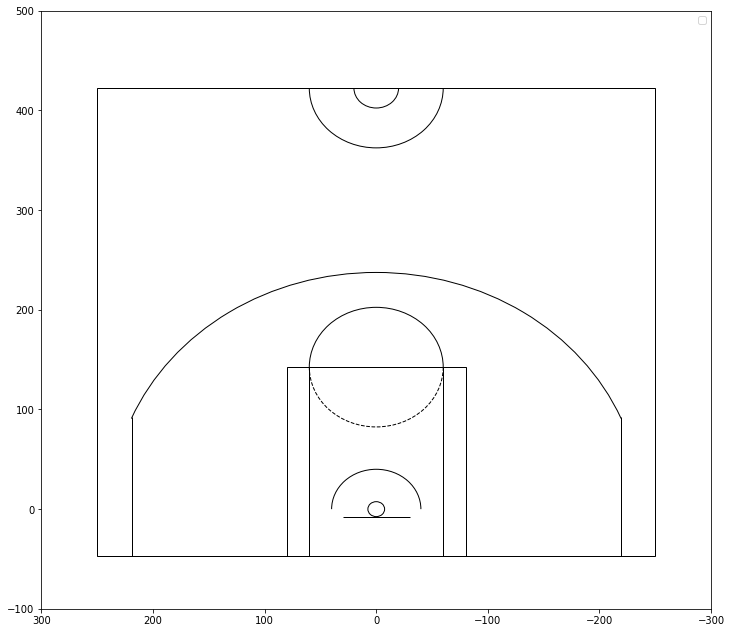

In [340]:
select_Team = 'SAC, Kings'
select_Year = '2017-18'

paramsRoster.update({'TeamID':team_Dict[select_Team]})
paramsRoster.update({'Season':select_Year})

roster = get_nba_data('commonteamroster',paramsRoster)
roster_Dict = dict(roster.set_index('PLAYER').PLAYER_ID)

team_menu = Dropdown(options=team_Dict, label=select_Team)

seasons = [str(i)+"-"+str(i+1)[-2:] for i in range(1996,2018)]
season_menu = Dropdown(options = seasons,label = select_Year) #Make this a slider or something nicer

season_types = ['Regular Season','Playoffs']
season_type_menu = Dropdown(options = season_types, label = 'Regular Season')

player_menu = Dropdown(options = roster_Dict)

fetch_button = Button(description='Get Shot Chart', icon='check')


fig, ax = plt.subplots()
plt.close(fig)


fetch_button.on_click(plot_chart)
team_menu.observe(update_team, names='value')
season_menu.observe(update_year,names='value')
display(team_menu, season_menu, season_type_menu,player_menu, fetch_button)


#### problem above with clearing shot chart, still prints new one below it but not ideal. Could not find solution online


### 3. Downloading data with changing widget states.
I think I just did that?

### 4. Data transformations and visualization

Just going to explore a number of things. First lets look at how LeBron Jame's shot attempts by zone vary by quarter

In [378]:
params.update({'PlayerID':'2544',
               'TeamID':'0',
               'Season':'2017-18',
               'SeasonType':'Regular Season',
               'TeamID':'1610612739	'
})
shotdata = get_nba_data('shotchartdetail', params)
len(shotdata) #Should be 1580

99

Lets get average shots per quarter

In [379]:
shotdata = shotdata.groupby(['PERIOD']).sum()
shotdata.SHOT_ATTEMPTED_FLAG/=82.0
shotdata.SHOT_MADE_FLAG/=82.0
shotdata["FG_PCT"] = shotdata.SHOT_MADE_FLAG/shotdata.SHOT_ATTEMPTED_FLAG
shotdata["AvgDistance"] = shotdata.SHOT_DISTANCE/(shotdata.SHOT_ATTEMPTED_FLAG*82)
shotdata.loc[:,['SHOT_ATTEMPTED_FLAG','SHOT_MADE_FLAG','FG_PCT','AvgDistance']]

,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,FG_PCT,AvgDistance
PERIOD,,,,
1,0.353659,0.146341,0.413793,9.586207
2,0.243902,0.134146,0.550000,9.800000
3,0.329268,0.182927,0.555556,10.148148
4,0.280488,0.146341,0.521739,14.869565


We see he shoots much better in first half and really well in overtime.
Lets do some aggregation to see how number of shots varies from zone by quarter

In [343]:
shotdata = get_nba_data('shotchartdetail', params)
shotdata = shotdata.groupby(['PERIOD','SHOT_ZONE_RANGE']).sum()
shotdata.SHOT_ATTEMPTED_FLAG/=82.0
shotdata.SHOT_MADE_FLAG/=82.0
shotdata["FG_PCT"] = shotdata.SHOT_MADE_FLAG/shotdata.SHOT_ATTEMPTED_FLAG
shotdata.loc[:,['SHOT_ATTEMPTED_FLAG','SHOT_MADE_FLAG','FG_PCT']]

SHOT_ATTEMPTED_FLAG  SHOT_MADE_FLAG    FG_PCT
PERIOD SHOT_ZONE_RANGE                                               
1      16-24 ft.                   0.707317        0.317073  0.448276
       24+ ft.                     0.914634        0.353659  0.386667
       8-16 ft.                    0.536585        0.207317  0.386364
       Less Than 8 ft.             3.439024        2.353659  0.684397
2      16-24 ft.                   0.439024        0.182927  0.416667
       24+ ft.                     0.939024        0.329268  0.350649
       8-16 ft.                    0.500000        0.182927  0.365854
       Less Than 8 ft.             2.256098        1.670732  0.740541
3      16-24 ft.                   0.670732        0.207317  0.309091
       24+ ft.                     1.670732        0.682927  0.408759
       8-16 ft.                    0.548780        0.243902  0.444444
       Less Than 8 ft.             2.024390        1.317073  0.650602
4      16-24 ft.                   0.439024        0.121951  0.277778
       24+ ft.                     1.390244        0.439024  0.315789
       8-16 ft.                    0.536585        0.256098  0.477273
       Back Court Shot             0.012195        0.000000  0.000000
       Less Than 8 ft.             2.170732        1.524390  0.702247
5      16-24 ft.                   0.012195        0.012195  1.000000
       24+ ft.                     0.024390        0.012195  0.500000
       8-16 ft.                    0.012195        0.012195  1.000000
       Less Than 8 ft.             0.024390        0.024390  1.000000

In [344]:
#Slightly cleaner
shotdata.loc[:,['SHOT_ATTEMPTED_FLAG','FG_PCT']].unstack()

SHOT_ATTEMPTED_FLAG                                      \
SHOT_ZONE_RANGE           16-24 ft.   24+ ft.  8-16 ft. Back Court Shot   
PERIOD                                                                    
1                          0.707317  0.914634  0.536585             NaN   
2                          0.439024  0.939024  0.500000             NaN   
3                          0.670732  1.670732  0.548780             NaN   
4                          0.439024  1.390244  0.536585        0.012195   
5                          0.012195  0.024390  0.012195             NaN   

                                   FG_PCT                                      \
SHOT_ZONE_RANGE Less Than 8 ft. 16-24 ft.   24+ ft.  8-16 ft. Back Court Shot   
PERIOD                                                                          
1                      3.439024  0.448276  0.386667  0.386364             NaN   
2                      2.256098  0.416667  0.350649  0.365854             NaN   
3                      2.024390  0.309091  0.408759  0.444444             NaN   
4                      2.170732  0.277778  0.315789  0.477273             0.0   
5                      0.024390  1.000000  0.500000  1.000000             NaN   

                                 
SHOT_ZONE_RANGE Less Than 8 ft.  
PERIOD                           
1                      0.684397  
2                      0.740541  
3                      0.650602  
4                      0.702247  
5                      1.000000

Could use pivot tables to show the same thing, but then we're missing FG PCT so we use shot distance again though probably not going to be interesting since we're already grouped on that

In [345]:
shotdata = get_nba_data('shotchartdetail', params)
shotdata.SHOT_ATTEMPTED_FLAG/=82.0
shotdata.SHOT_MADE_FLAG/=82.0 #Still want this per game. Will look weird before aggregation
#shotdata["FGpct"] = SHOT_

shotdata.pivot_table(index='PERIOD',columns='SHOT_ZONE_RANGE',
                    aggfunc={'SHOT_ATTEMPTED_FLAG':sum,'SHOT_DISTANCE':'mean'})


SHOT_ATTEMPTED_FLAG                                      \
SHOT_ZONE_RANGE           16-24 ft.   24+ ft.  8-16 ft. Back Court Shot   
PERIOD                                                                    
1                          0.707317  0.914634  0.536585             NaN   
2                          0.439024  0.939024  0.500000             NaN   
3                          0.670732  1.670732  0.548780             NaN   
4                          0.439024  1.390244  0.536585        0.012195   
5                          0.012195  0.024390  0.012195             NaN   

                                SHOT_DISTANCE                        \
SHOT_ZONE_RANGE Less Than 8 ft.     16-24 ft.    24+ ft.   8-16 ft.   
PERIOD                                                                
1                      3.439024     19.068966  25.120000  12.068182   
2                      2.256098     18.638889  25.623377  11.585366   
3                      2.024390     18.781818  25.627737  12.333333   
4                      2.170732     19.222222  25.596491  11.909091   
5                      0.024390     17.000000  23.500000  15.000000   

                                                 
SHOT_ZONE_RANGE Back Court Shot Less Than 8 ft.  
PERIOD                                           
1                           NaN        1.517730  
2                           NaN        1.513514  
3                           NaN        1.728916  
4                          75.0        1.567416  
5                           NaN        0.500000

### Extra: Reverse Shot Charts

Below I attempted to use a series of maps and various data sources to create shot charts for whether or not a player was on the court. It did not go so well.

Ended up working but took way way longer than I'd like. Also code is slow clunky and ugly

Lets try looking at it for on off data.

In [346]:
params.update({'PlayerID':'0',
               'Season':'2017-18',
               'SeasonType':'Regular Season',
               'TeamID':'1610612739',
               'OpponentTeamID':'1610612755'
              })
              
shotdata = get_nba_data('shotchartdetail',params)
sampleGameID = shotdata.GAME_ID.drop_duplicates()[0]
sampleGameID

'0021700291'

In [347]:
paramGame = {'GameID':'0021700291',
             'EndPeriod':'10',
             'StartPeriod':'1'
            }
playByPlay = get_nba_data('playbyplayv2',paramGame)
subData = playByPlay.query('EVENTMSGTYPE == 8')[['HOMEDESCRIPTION','VISITORDESCRIPTION','PERIOD','PCTIMESTRING']]
#Add a continuous time map to the problem. Number of seconds remaining in game
subData["TimeLeft"] = (4-subData.PERIOD)*12*60 + subData.PCTIMESTRING.str.split(":").str.get(0).astype(int)*60 + \
                        subData.PCTIMESTRING.str.split(":").str.get(1).astype(int)
subData = subData.drop(['PERIOD','PCTIMESTRING'],axis=1)
subData.head()

,HOMEDESCRIPTION,VISITORDESCRIPTION,TimeLeft
34,SUB: McConnell FOR Saric,None,2630
48,SUB: Johnson FOR Redick,None,2554
49,SUB: Bayless FOR Embiid,None,2554
54,SUB: Luwawu-Cabarrot FOR Covington,None,2538
63,None,SUB: Korver FOR Smith,2503


Our next step is to get data into some form where we can index on time and player to determine if they are in or not.

A few steps needed first. A way to map last name to playerID as well as additional datapoints representing starters checking in at time 2880 and those ending a game ending at 0. Also need to pay attention to overtimes.

Another possible hiccup would be the event where two players on one team share a last name but I do not see it at this point.

Before we further cut up subData we import our new datasets. 

From an [this game]( we see several box score based JSON files which should be suffient. Endpnt- boxscoretraditionalv2 seems most useful and concise. This file also provides some data we can use to check consitency of some of our estimates

In [348]:
paramBS = {'GameID':'0021700291',
           'EndPeriod':'10',
           'EndRange': str(12*60*10), #A theoretic 10 quarter game
           'RangeType':'0',
           'StartPeriod':'1',
           'StartRange':'0'          
          }
boxScoreDataRaw = get_nba_data('boxscoretraditionalv2',paramBS)
boxScoreDataRaw.head(20)

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,0021700291,1610612739,CLE,Cleveland,2544,LeBron James,F,,31:03,12.0,...,3.0,11.0,14.0,6.0,0.0,0.0,3.0,0.0,30.0,1.0
1,0021700291,1610612739,CLE,Cleveland,203109,Jae Crowder,F,,20:33,0.0,...,0.0,2.0,2.0,0.0,1.0,0.0,2.0,3.0,2.0,-3.0
2,0021700291,1610612739,CLE,Cleveland,201567,Kevin Love,C,,24:47,4.0,...,2.0,1.0,3.0,2.0,1.0,0.0,1.0,4.0,13.0,0.0
3,0021700291,1610612739,CLE,Cleveland,2747,JR Smith,G,,27:49,4.0,...,0.0,3.0,3.0,1.0,0.0,0.0,0.0,1.0,11.0,9.0
4,0021700291,1610612739,CLE,Cleveland,101181,Jose Calderon,G,,22:57,0.0,...,1.0,0.0,1.0,5.0,2.0,0.0,1.0,4.0,0.0,-2.0
5,0021700291,1610612739,CLE,Cleveland,2594,Kyle Korver,,,21:21,3.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,9.0,25.0
6,0021700291,1610612739,CLE,Cleveland,2548,Dwyane Wade,,,24:37,5.0,...,1.0,3.0,4.0,5.0,0.0,2.0,2.0,1.0,15.0,21.0
7,0021700291,1610612739,CLE,Cleveland,101112,Channing Frye,,,18:35,4.0,...,0.0,3.0,3.0,2.0,2.0,0.0,0.0,4.0,12.0,23.0
8,0021700291,1610612739,CLE,Cleveland,201145,Jeff Green,,,27:27,6.0,...,4.0,6.0,10.0,3.0,0.0,1.0,1.0,0.0,14.0,25.0
9,0021700291,1610612739,CLE,Cleveland,202697,Iman Shumpert,,,6:55,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0


Gives us information on who is starting, a name to Player_ID map we  can use as well as total time each player plays.

No information on home team so we'll do a map of (team abbreviation, player last name) to player ID.

We construct that below along with a list of our starters

In [349]:
boxScoreData = boxScoreDataRaw.copy()
boxScoreData['key']  = boxScoreData.TEAM_ABBREVIATION+boxScoreData.PLAYER_NAME.str.split(" ").str.get(1)
boxScoreData = boxScoreData.set_index(['key']) #Create key as mentioned and assign it

boxScoreData = boxScoreData.loc[:,['PLAYER_ID','START_POSITION','MIN']]
print(boxScoreData.head())
print('\n')
print("boxScoreData.PLAYER_ID['CLEJAMES']= %s"  % boxScoreData.PLAYER_ID['CLEJames'])

starters = boxScoreData.query("START_POSITION != ''")
print('\n')

print("starters.PLAYER_ID = %s" % starters.PLAYER_ID)

             PLAYER_ID START_POSITION    MIN
key                                         
CLEJames          2544              F  31:03
CLECrowder      203109              F  20:33
CLELove         201567              C  24:47
CLESmith          2747              G  27:49
CLECalderon     101181              G  22:57


boxScoreData.PLAYER_ID['CLEJAMES']= 2544


starters.PLAYER_ID = key
CLEJames           2544
CLECrowder       203109
CLELove          201567
CLESmith           2747
CLECalderon      101181
PHICovington     203496
PHISaric         203967
PHIEmbiid        203954
PHIRedick        200755
PHISimmons      1627732
Name: PLAYER_ID, dtype: int64


With this we return to our subData, sort it out, add starters check in at 0. No explicit statement of which team is home but we see through convention that away team is on top of box score.

In [350]:
awayAbbrev, homeAbbrev = boxScoreDataRaw.TEAM_ABBREVIATION.drop_duplicates()
#When we split "SUB ___ out for ___" we will preface last name with their team abbreviation

subDataClean = subData

def assignmentFunc(row):
    subIn = ""
    subOut = ""
    if(row.HOMEDESCRIPTION):
        subIn, subOut = row.HOMEDESCRIPTION.split()[1:4:2]
        prefix = homeAbbrev
    else:
        subIn, subOut = row.VISITORDESCRIPTION.split()[1:4:2]
        prefix = awayAbbrev
    row['SubIn']= boxScoreData.PLAYER_ID[prefix + subIn]
    row['SubOut'] = boxScoreData.PLAYER_ID[prefix + subOut]
    inRow = pd.Series([row['SubIn'],'in',row.TimeLeft],index=['Player','InOut','TimeLeft'])
    outRow = pd.Series([row['SubOut'],'out',row.TimeLeft],index=['Player','InOut','TimeLeft'])
    return(pd.concat([inRow,outRow]))

subDataClean = subDataClean.apply(assignmentFunc,axis=1)

idx = pd.IndexSlice
subDataClean = pd.concat([subDataClean.iloc[idx[:,0:3]], subDataClean.iloc[idx[:,2:5]]])
subDataClean = subDataClean.set_index(["Player","TimeLeft"]).sort_index()

print(subDataClean.head())

print("subDataClean.loc[boxScoreData.PLAYER_ID['CLEJames'],:] = \n %s"  % subDataClean.loc[boxScoreData.PLAYER_ID['CLEJames'],:])


                InOut
Player TimeLeft      
2544   279        out
       506         in
       829        out
       1868        in
       2283       out
subDataClean.loc[boxScoreData.PLAYER_ID['CLEJames'],:] = 
          InOut
TimeLeft      
279        out
506         in
829        out
1868        in
2283       out


In [351]:
#Remember to add starters at 0
starters = boxScoreData.START_POSITION!=''
subDataFill = boxScoreData.copy()
subDataFill["TimeLeft"] = 0
subDataFill["InOut"] = "out"
subFill2 = boxScoreData[starters].copy()
subFill2["TimeLeft"] = 60*48
subFill2["InOut"]='in'
subDataFill = subDataFill.append(subFill2)
subDataFill = subDataFill.rename(columns={'PLAYER_ID':'Player'}).set_index(["Player","TimeLeft"])\
                .sort_index().drop(["START_POSITION","MIN"],axis=1)
subDataFill.head()
subDataClean = subDataClean.append(subDataFill).sort_index()

In [352]:
subDataClean.head()

InOut
Player TimeLeft      
2544   0          out
       279        out
       506         in
       829        out
       1868        in

Now what do we do with this?. Main Goal to work back into our widget for whether or not some player is on the floor.

Definitely need to make it less cumbersome.

In [353]:
subDataClean.loc[[203954]]

InOut
Player TimeLeft      
203954 0          out
       405        out
       793        out
       1653        in
       1912       out
       2380        in
       2554       out
       2880        in

In [354]:
params.update({'PlayerID':'0',
               'Season':season_menu.value,
               'SeasonType':season_type_menu.value,
               'TeamID':'1610612739',
               'Game_ID':'0021700291'        
    })

shotdata = get_nba_data('shotchartdetail',params)
print(len(shotdata))
shotdata.head()

335


,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021700291,8,201567,Kevin Love,1610612739,Cleveland Cavaliers,1,11,21,...,Right Side Center(RC),16-24 ft.,20,81,189,1,0,20171127,PHI,CLE
1,Shot Chart Detail,0021700291,11,201567,Kevin Love,1610612739,Cleveland Cavaliers,1,10,57,...,Left Side Center(LC),24+ ft.,25,-195,163,1,0,20171127,PHI,CLE
2,Shot Chart Detail,0021700291,665,2544,LeBron James,1610612739,Cleveland Cavaliers,1,10,40,...,Center(C),Less Than 8 ft.,6,-49,43,1,0,20171127,PHI,CLE
3,Shot Chart Detail,0021700291,15,2544,LeBron James,1610612739,Cleveland Cavaliers,1,10,36,...,Center(C),Less Than 8 ft.,1,14,-7,1,1,20171127,PHI,CLE
4,Shot Chart Detail,0021700291,18,2544,LeBron James,1610612739,Cleveland Cavaliers,1,10,21,...,Center(C),Less Than 8 ft.,2,-8,23,1,1,20171127,PHI,CLE


Now we find how to check if embiid is on floor, for example.

In [355]:
shotdata['TimeLeft']= (4-shotdata['PERIOD'])*12*60 + shotdata['MINUTES_REMAINING']*60 + shotdata['SECONDS_REMAINING']

In [356]:
embiidStatus = subDataClean.loc[idx[203954,:]]
embiidStatus

,InOut
TimeLeft,
0,out
405,out
793,out
1653,in
1912,out
2380,in
2554,out
2880,in


In [357]:
embiidStatus[list((pd.Series(embiidStatus.index)-2200)>0)].iloc[0][0]

'in'

In [358]:
shotdata["embiidOnFloor"] = 0
def embiidOnFloor(x):
    if embiidStatus[list((pd.Series(embiidStatus.index)-x.TimeLeft)>0)].iloc[0][0]=='in':
        x.embiidOnFloor = 1
    return(x)
shotdata.apply(embiidOnFloor,axis=1).head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,TimeLeft,embiidOnFloor
0,Shot Chart Detail,0021700291,8,201567,Kevin Love,1610612739,Cleveland Cavaliers,1,11,21,...,20,81,189,1,0,20171127,PHI,CLE,2841,1
1,Shot Chart Detail,0021700291,11,201567,Kevin Love,1610612739,Cleveland Cavaliers,1,10,57,...,25,-195,163,1,0,20171127,PHI,CLE,2817,1
2,Shot Chart Detail,0021700291,665,2544,LeBron James,1610612739,Cleveland Cavaliers,1,10,40,...,6,-49,43,1,0,20171127,PHI,CLE,2800,1
3,Shot Chart Detail,0021700291,15,2544,LeBron James,1610612739,Cleveland Cavaliers,1,10,36,...,1,14,-7,1,1,20171127,PHI,CLE,2796,1
4,Shot Chart Detail,0021700291,18,2544,LeBron James,1610612739,Cleveland Cavaliers,1,10,21,...,2,-8,23,1,1,20171127,PHI,CLE,2781,1


Succesful in this particular Example. We can try to build a function or a handful of ideas next.
Key things. We can only do this on a per game basis, sort of. Could well just map all game ID against said team. 
We will end up pulling way too much data if we're not careful.

Also still need to handle the overtimes.

Lets just quickly try to make the Joel Embiid on the Court shot chart

In [359]:
params.update({'PlayerID':'0',
               'Season':'2017-18',
               'SeasonType':'Regular Season',
               'TeamID':'0',
               'OpponentTeamID':'1610612755',
               'lastNGames':'82'
              })
              
shotdata = get_nba_data('shotchartdetail',params)

print(len(shotdata))
shotdata.head()

7185


,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021700006,8,203078,Bradley Beal,1610612764,Washington Wizards,1,11,44,...,Center(C),8-16 ft.,12,26,127,1,0,20171018,WAS,PHI
1,Shot Chart Detail,0021700006,11,203490,Otto Porter Jr.,1610612764,Washington Wizards,1,11,30,...,Left Side Center(LC),16-24 ft.,16,-130,100,1,1,20171018,WAS,PHI
2,Shot Chart Detail,0021700006,17,203490,Otto Porter Jr.,1610612764,Washington Wizards,1,11,8,...,Right Side(R),16-24 ft.,16,163,18,1,1,20171018,WAS,PHI
3,Shot Chart Detail,0021700006,21,202322,John Wall,1610612764,Washington Wizards,1,10,38,...,Left Side(L),8-16 ft.,14,-103,97,1,0,20171018,WAS,PHI
4,Shot Chart Detail,0021700006,26,203490,Otto Porter Jr.,1610612764,Washington Wizards,1,10,12,...,Right Side(R),16-24 ft.,17,177,2,1,0,20171018,WAS,PHI


Above we have data for every shot taken against the 76ers in the 2017-2018 Regular Season. 
We want to assign a variable for whether or not some player was on the court. In this case we'll use embiid but keep the code flexible enough to add Ben Simmons for example, Actually we might need to stick to embiid for now.

In [360]:
shotdata['TimeLeft']= (4-shotdata['PERIOD'])*12*60 + shotdata['MINUTES_REMAINING']*60 + shotdata['SECONDS_REMAINING']
shotdata["playerOnCourt"] = 0
#When we split "SUB ___ out for ___" we will preface last name with their team abbreviation

def assignmentFunc(row,boxScoreData,awayAbbrev, homeAbbrev):
    subIn = ""
    subOut = ""
    if(row.HOMEDESCRIPTION):
        subIn, subOut = row.HOMEDESCRIPTION.split("FOR")
        subIn = subIn.split("SUB: ")[1].strip()
        subOut= subOut.strip()
        prefix = homeAbbrev
        
    else:
        subIn, subOut = row.VISITORDESCRIPTION.split("FOR")
        subIn = subIn.split("SUB: ")[1].strip()
        subOut = subOut.strip()
        prefix = awayAbbrev
#    print(prefix+subIn)
#    print(prefix+subOut)

    try:
        if type(boxScoreData.PLAYER_ID[prefix+ subIn])==np.int64:
            row['SubIn']= boxScoreData.PLAYER_ID[prefix + subIn]
        else:
            row['SubIn']= boxScoreData.PLAYER_ID[prefix + subIn].iloc[0]
    except:
 #       print("Probably Nene")
        row['SubIn'] = None
        
    try:
        if type(boxScoreData.PLAYER_ID[prefix+ subOut])==np.int64:
            row['SubOut'] = boxScoreData.PLAYER_ID[prefix + subOut]
        else:
            row['SubOut'] = boxScoreData.PLAYER_ID[prefix + subOut].iloc[0]
 
    except:
    #    print("Probably Nene")
        row['SubOut'] = None
        
    inRow = pd.Series([row['SubIn'],'in',row.TimeLeft],index=['Player','InOut','TimeLeft'])
    outRow = pd.Series([row['SubOut'],'out',row.TimeLeft],index=['Player','InOut','TimeLeft'])

    return(pd.concat([inRow,outRow]))


def playerOnCourt(x):
    global currGAME_ID
    
    global playerStatus
    
    if x.GAME_ID != currGAME_ID:
#        print(x.GAME_ID)
        currGAMEID = x.GAME_ID
        paramBS = {'GameID':x.GAME_ID,
               'EndPeriod':'10',
               'EndRange': str(12*60*10), #A theoretic 10 quarter game
               'RangeType':'0',
               'StartPeriod':'1',
               'StartRange':'0'}

        boxScoreDataRaw = get_nba_data('boxscoretraditionalv2',paramBS)
        boxScoreData = boxScoreDataRaw.copy()
        awayAbbrev, homeAbbrev = boxScoreDataRaw.TEAM_ABBREVIATION.drop_duplicates()
        boxScoreData['key']= boxScoreData.TEAM_ABBREVIATION+boxScoreData.PLAYER_NAME.str.split(" ").str.slice(1,4).str.join(" ")
        boxScoreData = boxScoreData.set_index(['key']) #Create key as mentioned and assign it

        paramGame = {'GameID':x.GAME_ID,
                 'EndPeriod':'10',
                 'StartPeriod':'1'}

        playByPlay = get_nba_data('playbyplayv2',paramGame)
        subData = playByPlay.query('EVENTMSGTYPE == 8')[['HOMEDESCRIPTION','VISITORDESCRIPTION','PERIOD','PCTIMESTRING']]
        #Add a continuous time map to the problem. Number of seconds remaining in game

        subData["TimeLeft"] = (4-subData.PERIOD)*12*60 + subData.PCTIMESTRING.str.split(":").str.get(0).astype(int)*60 + \
                                subData.PCTIMESTRING.str.split(":").str.get(1).astype(int)
        subData = subData.drop(['PERIOD','PCTIMESTRING'],axis=1)
        subData.head()

        boxScoreData = boxScoreData.loc[:,['PLAYER_ID','START_POSITION','MIN']]
        starters = boxScoreData.query("START_POSITION != ''")

        subDataClean = subData.apply(lambda x: assignmentFunc(x,boxScoreData,awayAbbrev, homeAbbrev),axis=1)
        idx = pd.IndexSlice
        subDataClean = pd.concat([subDataClean.iloc[idx[:,0:3]], subDataClean.iloc[idx[:,2:5]]])
    #    print(subDataClean.head())
        subDataClean = subDataClean.set_index(["Player","TimeLeft"]).sort_index()


            #Remember to add starters at 0
        starters = boxScoreData.START_POSITION!=''
        subDataFill = boxScoreData.copy()
        subDataFill["TimeLeft"] = 0
        subDataFill["InOut"] = "out"
        subFill2 = boxScoreData[starters].copy()
        subFill2["TimeLeft"] = 60*48
        subFill2["InOut"]='in'
        subDataFill = subDataFill.append(subFill2)
        subDataFill = subDataFill.rename(columns={'PLAYER_ID':'Player'}).set_index(["Player","TimeLeft"])\
                        .sort_index().drop(["START_POSITION","MIN"],axis=1)
        subDataFill.head()
        subDataClean = subDataClean.append(subDataFill).sort_index()
        ugly = True
        try:
            temp = list(boxScoreData.MIN[boxScoreData.PLAYER_ID == Select_Player])[0]==None
            if temp:
                ugly = False
        except:
            ugly = False
        if (ugly):
            playerStatus = subDataClean.loc[idx[Select_Player],:]
        else:
            playerStatus.InOut='out'
            
    if playerStatus[list((pd.Series(playerStatus.index)-x.TimeLeft)>0)].iloc[0][0]=='in':
        x.playerOnCourt = 1
        
    currGAME_ID = x.GAME_ID
    return(x)


Select_Player = 203954
currGAME_ID = ''
playerStatus = embiidStatus
embiidIndicator = shotdata.apply(playerOnCourt,axis=1).playerOnCourt
shotdata['embiidOnCourt'] = embiidIndicator

Select_Player = 1627732
currGAME_ID = ''
playerStatus = embiidStatus
simmonsIndicator = shotdata.apply(playerOnCourt,axis=1).playerOnCourt
shotdata['simmonsOnCourt']= simmonsIndicator

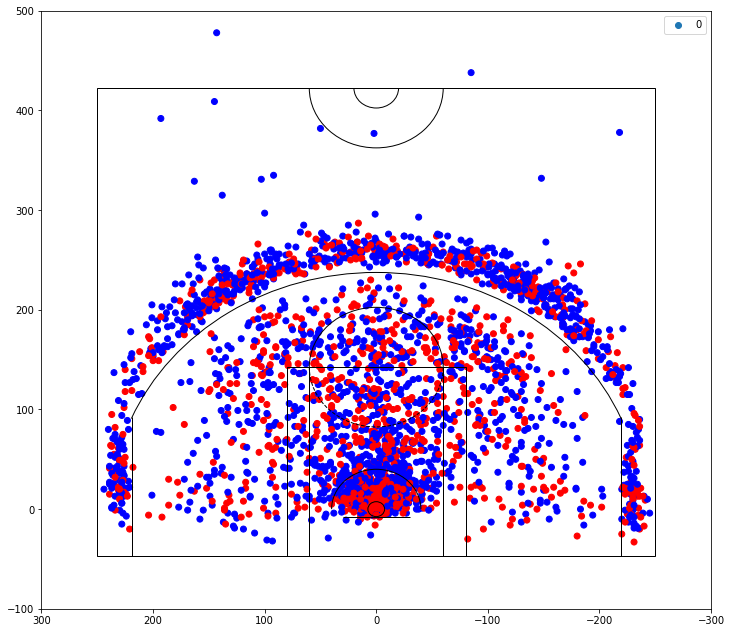

In [361]:
shotdataWEmbiid = shotdata[shotdata.embiidOnCourt==1]
shotdataWoEmbiid = shotdata[shotdata.embiidOnCourt==0]
plt.figure(figsize=(12,11))
plt.scatter(shotdataWEmbiid.LOC_X, shotdataWEmbiid.LOC_Y,c=shotdataWEmbiid.SHOT_MADE_FLAG, cmap='bwr')
#Added a color map
plt.legend(shotdata.SHOT_MADE_FLAG)
draw_court(outer_lines=True)

plt.xlim(300,-300)
plt.ylim(-100,500)
plt.show()

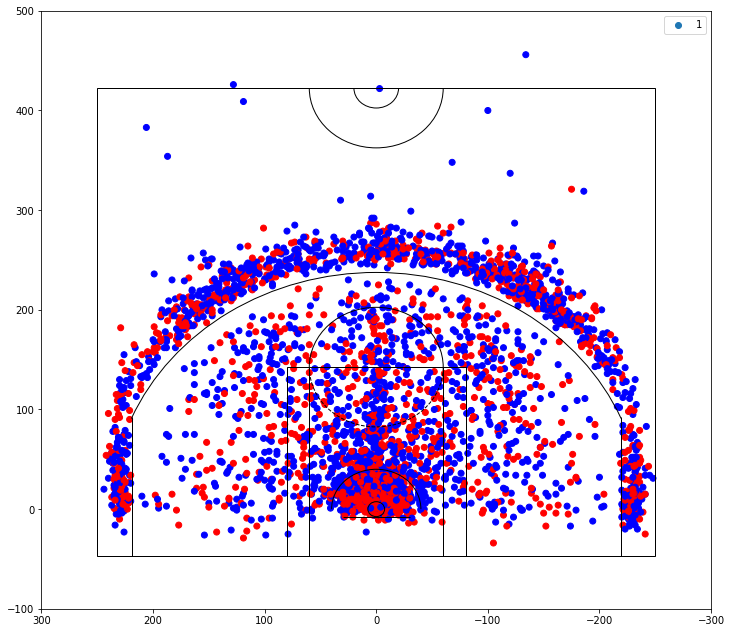

In [362]:
plt.figure(figsize=(12,11))
plt.scatter(shotdataWoEmbiid.LOC_X, shotdataWoEmbiid.LOC_Y,c=shotdataWoEmbiid.SHOT_MADE_FLAG, cmap='bwr')
#Added a color map
plt.legend(shotdataWoEmbiid.SHOT_MADE_FLAG)
draw_court(outer_lines=True)

plt.xlim(300,-300)
plt.ylim(-100,500)
plt.show()

In [363]:
shotdata.groupby('embiidOnCourt')['SHOT_MADE_FLAG','SHOT_DISTANCE'].mean()

,SHOT_MADE_FLAG,SHOT_DISTANCE
embiidOnCourt,,
0,0.444079,13.565283
1,0.422208,13.759357


In [364]:
shotdata.pivot_table(index=['embiidOnCourt','simmonsOnCourt'],
                     columns = ['SHOT_ZONE_RANGE'],aggfunc={'SHOT_MADE_FLAG':'mean'})

SHOT_MADE_FLAG                      \
SHOT_ZONE_RANGE                   16-24 ft.   24+ ft.  8-16 ft.   
embiidOnCourt simmonsOnCourt                                      
0             0                    0.356250  0.364017  0.391509   
              1                    0.388316  0.350112  0.404145   
1             0                    0.421875  0.357647  0.419048   
              1                    0.378092  0.311774  0.422156   

                                                              
SHOT_ZONE_RANGE              Back Court Shot Less Than 8 ft.  
embiidOnCourt simmonsOnCourt                                  
0             0                          0.0        0.588968  
              1                          0.0        0.550574  
1             0                          0.0        0.505219  
              1                          0.0        0.526619

In [365]:
shotdata.pivot_table(index=['embiidOnCourt','simmonsOnCourt'],aggfunc={'SHOT_MADE_FLAG':'mean'})

SHOT_MADE_FLAG
embiidOnCourt simmonsOnCourt                
0             0                     0.454545
              1                     0.438216
1             0                     0.428137
              1                     0.418144